# LLM from scratch

The goal is to code from scratch (using Pytorch) a Transformer, more precisely a GPT-like model (using a decoder-only architecture). See discussion at the end for what's missing to build a full blown LLM.

Credits: a lot of the code is inspired by Andrej Karpathy's lectures, videos, and repositories, in particular
https://github.com/karpathy/nn-zero-to-hero
https://github.com/karpathy/makemore

I did not know at the time I prepared this notebook, but a fantastic reference which goes in a lot more depth, is Sebastian Raschka's book and codebase:
https://github.com/rasbt/LLMs-from-scratch

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import trange

What we will do here: train a generative model with political speeches (State of the Union).
The goal is to generate more speeches!

In [3]:
# main model and data hyperparameters
batch_size = 32 # number of sequences processed in parallel
block_size = 16 # maximum context length for predictions
n_token = 512 # number of tokens (used for world level tokenizer)
blank_token = n_token

# the rest of the hyper parameters are defined with the models
n_embed = 64 # size of hidden layer

Note: the hyper parameters were **not** optimised at all! Also, the code runs on CPU, not GPU. It is mostly for educational purposes.

## Part 1: Playing with the dataset

Let's download the dataset.

In [3]:
!wget https://raw.githubusercontent.com/nathanael-fijalkow/LLM_from_scratch/main/sotu.txt

--2024-03-30 18:40:07--  https://raw.githubusercontent.com/nathanael-fijalkow/LLM_from_scratch/main/sotu.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8003::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-03-30 18:40:07 ERROR 404: Not Found.



In [4]:
with open('sotu.txt', 'r', encoding='utf-8') as f:
    text = f.read()

text = text.lower()

In [5]:
data_size = len(text)
data_size

1279319

In [6]:
print(text[:1000])

mr. speaker, mr. president, and distinguished members of the house and senate,
honored guests, and fellow citizens: less than 3 weeks ago, i joined you on the
west front of this very building and, looking over the monuments to our proud
past, offered you my hand in filling the next page of american history with a
story of extended prosperity and continued peace. and tonight i'm back to offer
you my plans as well. the hand remains extended; the sleeves are rolled up;
america is waiting; and now we must produce. together, we can build a better
america.

it is comforting to return to this historic chamber. here, 22 years ago, i first
raised my hand to be sworn into public life. so, tonight i feel as if i'm
returning home to friends. and i intend, in the months and years to come, to
give you what friends deserve: frankness, respect, and my best judgment about
ways to improve america's future. in return, i ask for an honest commitment to
our common mission of progress. if we seize the oppor

We will start with a basic character-level tokenizer

In [7]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
# encoder: take a string, output a list of integers
encode = lambda s: [stoi[c] for c in s] 
# decoder: take a list of integers, output a string
decode = lambda l: ''.join([itos[i] for i in l]) 

print(itos)

{0: '\n', 1: ' ', 2: '!', 3: '"', 4: '$', 5: '%', 6: '&', 7: "'", 8: '(', 9: ')', 10: ',', 11: '-', 12: '.', 13: '/', 14: '0', 15: '1', 16: '2', 17: '3', 18: '4', 19: '5', 20: '6', 21: '7', 22: '8', 23: '9', 24: ':', 25: ';', 26: '?', 27: 'a', 28: 'b', 29: 'c', 30: 'd', 31: 'e', 32: 'f', 33: 'g', 34: 'h', 35: 'i', 36: 'j', 37: 'k', 38: 'l', 39: 'm', 40: 'n', 41: 'o', 42: 'p', 43: 'q', 44: 'r', 45: 's', 46: 't', 47: 'u', 48: 'v', 49: 'w', 50: 'x', 51: 'y', 52: 'z'}


In [8]:
test = "hello world"
test_encoded = encode(test)
test_encoded, decode(test_encoded)

([34, 31, 38, 38, 41, 1, 49, 41, 44, 38, 30], 'hello world')

In [9]:
test_encoded = torch.tensor(test_encoded)
test_tensor = F.one_hot(test_encoded, num_classes=vocab_size).float()
test_tensor, test_tensor.shape

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.

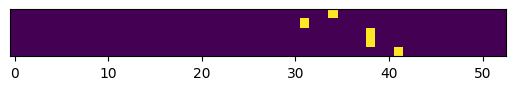

In [10]:
# The first 5 characters code for "hello"
plt.yticks([])
plt.imshow(test_tensor[:5]);

We encode the entire text dataset and store it into a `torch.Tensor`.

In [11]:
data = torch.tensor(encode(text))
print(data.shape)

torch.Size([1279319])


We split up the data into train and validation sets.

In [12]:
n = int(0.9*len(data)) 
# first 90% goes to training
train_data = data[:n]
# the rest goes to validation
val_data = data[n:]

`get_data` produces a random pair of consecutive characters, one-hot encoded.

In [13]:
def get_data(split):
    data = train_data if split == 'train' else val_data
    i = torch.randint(len(data) - 1, (1,))
    x = F.one_hot(data[i], num_classes=vocab_size).float()
    y = F.one_hot(data[i+1], num_classes=vocab_size).float()
    return x,y
        
get_data("train")

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

## Part 2: Bigram model

We define our first model, a very basic bigram model: it is a Markov chain, which chooses the next character based only on the current character. It uses cross entropy loss, illustrated below.

`W` is a `(vocab_size,vocab_size)` matrix. We use `nn.Parameter` to tell Pytorch that the entries of `W` are parameters of the model.

To define a model, we typically write two functions:
* `init`, which initialises the model,
* `forward`, which is how the model is run. 

`forward` takes either only an input `x`, or both an input `x` and the expected target `y`. The model returns two tensors: `logits` and `loss`:
* `logits` represents the predictions of the model on input `x`,
* `loss` computes the loss of the model on `x` for predicting `y`.

In [14]:
class Bigram(nn.Module):
    def __init__(self):
        super().__init__()
        self.W = nn.Parameter(torch.zeros((vocab_size, vocab_size)))

    def forward(self, x, y=None):
        logits = x @ self.W
        
        if y is None:
            loss = None
        else:
            loss = F.cross_entropy(logits, y)

        return logits, loss    

In [15]:
model = Bigram()
print(sum(p.numel() for p in model.parameters()), ' parameters')

2809  parameters


The code below illustrates how cross entropy loss is computed.

We consider some tensor `logits`, which is the output of the model on some (imaginary) input `x`. It assigns to each class (here, a class is a character) a float value. The `logits` are turned into a probabilistic distribution using a softmax (exponentiation and normalisation). For numerical stability we prefer to work with "log probabilities" as summing numbers is easier than multiplying them.

The target is some `y`, representing a class (in our case, a character).

In [17]:
number_classes_test = 5

logits = torch.randn(number_classes_test)
print("The input x: \n", logits)
logits_exped = logits.exp()
print("After exponentiation: \n", logits_exped)
probs = logits_exped / logits_exped.sum()
print("After normalisation: \n", probs)
print("\nThe two steps above are called softmax: \n", F.softmax(logits, 0))
logprobs = -probs.log()
print("\nWe work with log probabilities: \n", logprobs)

y = torch.randint(number_classes_test, (), dtype=torch.int64)
print("The target y: ", y.item())

loss = F.cross_entropy(logits, y)
print("The cross entropy loss: ", loss.item())

The input x: 
 tensor([-2.3578, -0.7919,  1.6708,  1.2615, -0.7398])
After exponentiation: 
 tensor([0.0946, 0.4530, 5.3162, 3.5308, 0.4772])
After normalisation: 
 tensor([0.0096, 0.0459, 0.5385, 0.3577, 0.0483])

The two steps above are called softmax: 
 tensor([0.0096, 0.0459, 0.5385, 0.3577, 0.0483])

We work with log probabilities: 
 tensor([4.6475, 3.0816, 0.6189, 1.0282, 3.0295])
The target y:  1
The cross entropy loss:  3.0816006660461426


Now we will write some boilerplate code for running, evaluating, and training models. Since this is still a warm-up we're not doing batches.

The code below shows how to use the model to generate text.

In [18]:
def generate_bigram(model, max_new_tokens = 200):
    idx = F.one_hot(torch.tensor(stoi["\n"]), num_classes=vocab_size).float()
    out = []
    for _ in range(max_new_tokens):
        # get the predictions
        logits, _ = model(idx)
        # logits.shape = (vocab_size)
        # apply softmax to get probabilities
        probs = F.softmax(logits, dim=0) 
        # probs.shape = (vocab_size)
        # sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1) 
        # idx_next.shape = (1)
        # append sampled index to the output sequence
        out.append(idx_next.item())
        idx = F.one_hot(idx_next.view(()), num_classes=vocab_size).float()

    return decode(out)

Since the model was not trained for now it produces garbage (it is a uniform distribution)!

In [24]:
print(generate_bigram(model))

1.m?vf0xq9th(b2oc:0yrl46y99."
ki6"-vj.pc(p2nm74 u'mkdmgfi
1s"q&)5j4-3)s.,b;f'1?%y/q5c&cg".7nhsq9'm7 g. 6lx/;f.tdu6eav?,gq) &7:)rw";6rm19i.'-g:"vzzl:;n,n,-w/k6,81advrr.&34-w(!1(eg&hzd/c$c'g e &p.(&ej5b


The code below makes an estimation of the loss by averaging on `eval_iters` samples of data.

In [25]:
@torch.no_grad()
def estimate_loss_no_batch(model, eval_iters = 100):
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x, y = get_data(split)
            _, loss = model(x, y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out

The code below for training is very generic. We iterate a number of times:
* sample data `(x,y)`
* forward pass: compute the loss on `(x,y)`
* reset the gradients for all parameters
* backward pass: compute the gradients, using `loss.backward()`
* run one step of gradient descent (here, the refined Adam optimizer, which adapts the learning rate)

When doing the forward pass, Pytorch creates computation graphs which are then used to compute the gradients.

In [26]:
def train_no_batch(model, n_iterations = 20000, learning_rate = 1e-3, eval_interval = 1000, eval_iters = 100):
    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    for iter in range(n_iterations):
        # every once in a while evaluate the loss on training and validation sets
        if iter % eval_interval == 0 or iter == n_iterations - 1:
            losses = estimate_loss_no_batch(model, eval_iters)
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        x,y = get_data("train")
        _, loss = model(x, y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

In [27]:
train_no_batch(model, n_iterations = 40000, learning_rate = 1e-3, eval_interval = 2000, eval_iters = 100)

step 0: train loss 3.9703, val loss 3.9703
step 2000: train loss 3.6700, val loss 3.6479
step 4000: train loss 3.3513, val loss 3.3616
step 6000: train loss 3.1573, val loss 3.1824
step 8000: train loss 3.0685, val loss 3.0020
step 10000: train loss 2.8461, val loss 2.8435
step 12000: train loss 2.7789, val loss 2.8211
step 14000: train loss 2.7506, val loss 2.6983
step 16000: train loss 2.7127, val loss 2.6846
step 18000: train loss 2.7043, val loss 2.6432
step 20000: train loss 2.5786, val loss 2.7071
step 22000: train loss 2.7645, val loss 2.5532
step 24000: train loss 2.6096, val loss 2.5636
step 26000: train loss 2.6663, val loss 2.5475
step 28000: train loss 2.5029, val loss 2.5812
step 30000: train loss 2.3959, val loss 2.4697
step 32000: train loss 2.7020, val loss 2.4483
step 34000: train loss 2.4368, val loss 2.6042
step 36000: train loss 2.4400, val loss 2.4085
step 38000: train loss 2.5458, val loss 2.6689
step 39999: train loss 2.3896, val loss 2.5130


The output of the trained bigram model should be a bit better than random...

In [30]:
print(generate_bigram(model))

spr s the esil6urino s itean in ctis."jwhathe hese dindidomo te wefonoun elive andz!/und7jin amorowa
halerefese alud, s mbto

steregeathastw)arime foield se, intie tece mongr re ton l tearn ns cin
fru


Let's try to understand what the bigram model learned. For this we will plot the "idealised" matrix, representing frequencies of apparition of consecutive characters. For readability we restrict ourselves to letters.

In [23]:
N = torch.zeros((26, 26), dtype=torch.int32)
shift = stoi['a']

for i in range(len(text) - 1):
    if text[i].isalpha() and text[i+1].isalpha():
        N[stoi[text[i]] - shift, stoi[text[i+1]]  - shift] += 1

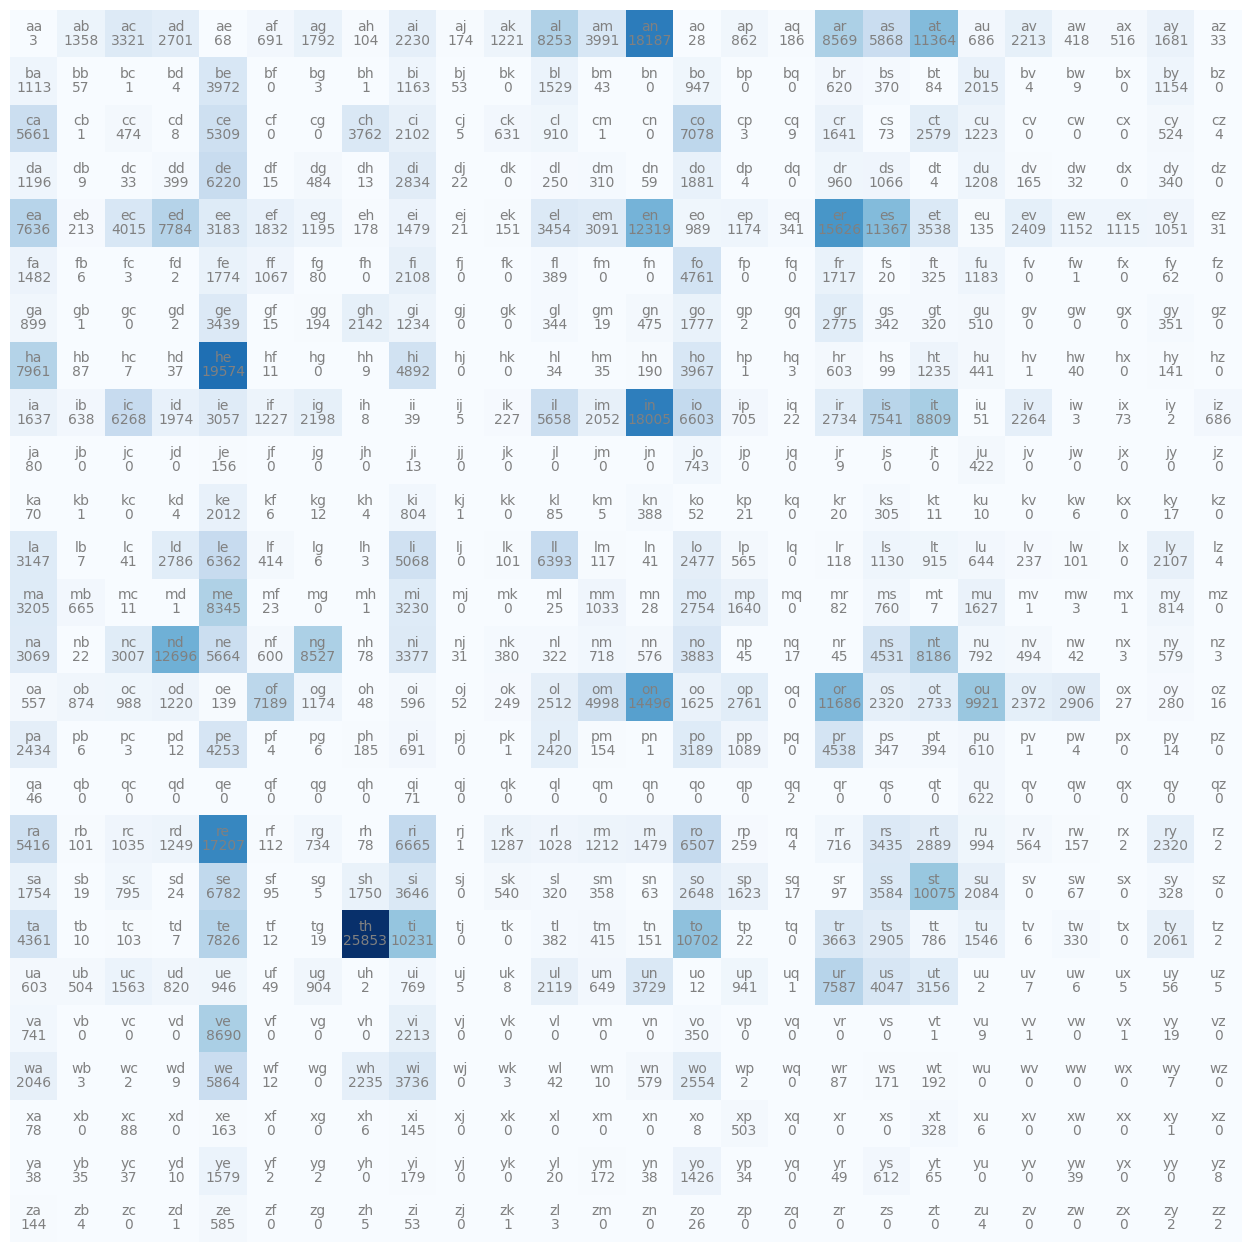

In [24]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(26):
    for j in range(26):
        chstr = itos[i + shift] + itos[j + shift]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

Now we plot in a similar way the matrix `model.W`. From far, the two matrices look similar, suggesting that the bigram model is indeed convering towards the frequency matrix.

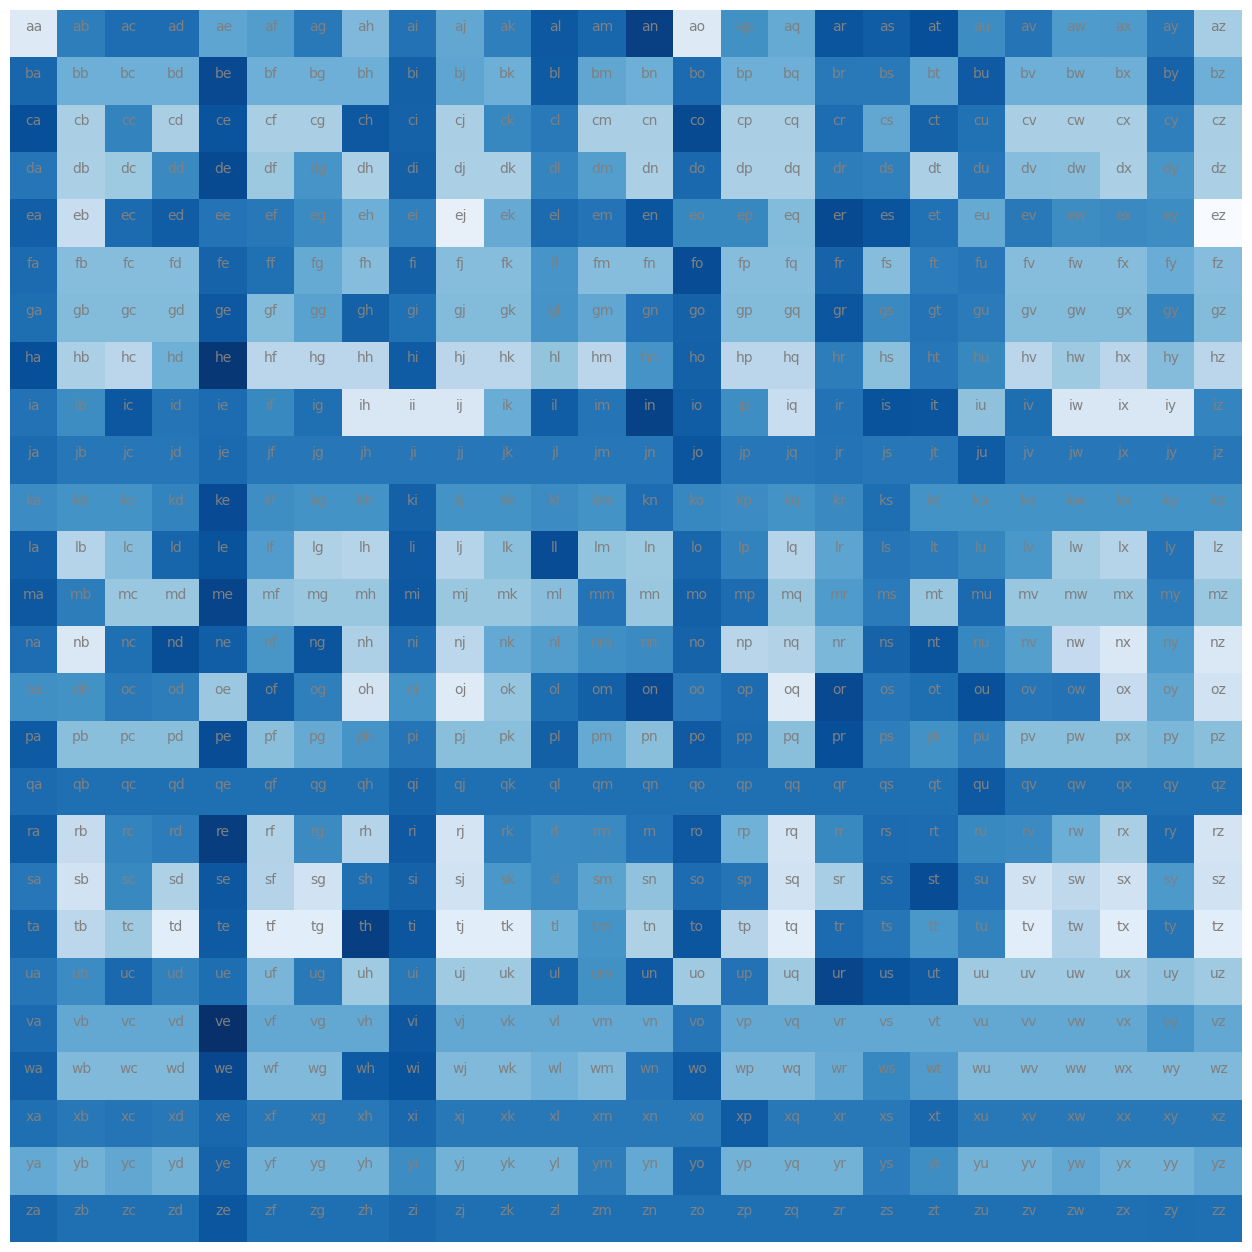

In [25]:
shift = stoi['a']

@torch.no_grad()
def plot_W(model):
    plt.figure(figsize=(16,16))
    W_letters = model.W[shift:shift + 26, shift:shift + 26]
    plt.imshow(W_letters, cmap='Blues')
    for i in range(26):
        for j in range(26):
            chstr = itos[i + shift] + itos[j + shift]
            plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
    plt.axis('off');
    
plot_W(model)

Before moving on to more expressive models, let us write the bigram model in a more Pytorch-friendly way.

Also, we add to the loss a regularisation term: `0.1 * (self.net.weights**2).mean()`. By adding this to the loss, we force the weights to be as small as possible, which helps generalisation.

In [26]:
class BigramProper(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Linear(vocab_size, vocab_size, bias=False)

    def forward(self, x, y=None):
        logits = self.net(x)
        
        if y is None:
            loss = None
        else:
            loss = F.cross_entropy(logits, y) + 0.1 * (self.net.weight**2).mean()

        return logits, loss    

In [27]:
model = BigramProper()
print(sum(p.numel() for p in model.parameters()), ' parameters')

train_no_batch(model, n_iterations = 40000, learning_rate = 1e-3, eval_interval = 2000, eval_iters = 100)
print("\n", generate_bigram(model))

2809  parameters
step 0: train loss 3.9831, val loss 3.9900
step 2000: train loss 3.6664, val loss 3.6425
step 4000: train loss 3.3370, val loss 3.4416
step 6000: train loss 3.1752, val loss 3.1987
step 8000: train loss 3.0742, val loss 3.1303
step 10000: train loss 2.9971, val loss 3.0396
step 12000: train loss 2.8542, val loss 2.9209
step 14000: train loss 2.9143, val loss 2.8852
step 16000: train loss 2.7688, val loss 2.7663
step 18000: train loss 2.8330, val loss 2.8964
step 20000: train loss 2.8331, val loss 2.8641
step 22000: train loss 2.7549, val loss 2.7682
step 24000: train loss 2.8944, val loss 2.9818
step 26000: train loss 2.8459, val loss 2.8174
step 28000: train loss 2.6661, val loss 2.7315
step 30000: train loss 2.8730, val loss 2.8511
step 32000: train loss 2.8090, val loss 2.6730
step 34000: train loss 2.6182, val loss 3.0906
step 36000: train loss 2.6643, val loss 2.7917
step 38000: train loss 2.7733, val loss 2.7884
step 39999: train loss 2.9310, val loss 2.8057

 m 

## Part 3: Word-level tokenizer

Instead of working at character level, we will now work at word level. The science of decomposing a text into tokens is a complicated one. Here we use `minbpe`, which implements the Byte Pair Encoding (BPE) algorithm commonly used in LLM tokenization.

In [31]:
from minbpe.minbpe import RegexTokenizer

The tokenizer takes a while to run so let's download a tokenizer (obtained using minbpe).

In [29]:
!wget https://raw.githubusercontent.com/nathanael-fijalkow/LLM_from_scratch/main/tok512.model
!wget https://raw.githubusercontent.com/nathanael-fijalkow/LLM_from_scratch/main/tok512.vocab

--2024-03-30 18:41:05--  https://raw.githubusercontent.com/nathanael-fijalkow/LLM_from_scratch/main/tok512.model
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-03-30 18:41:05 ERROR 404: Not Found.

--2024-03-30 18:41:05--  https://raw.githubusercontent.com/nathanael-fijalkow/LLM_from_scratch/main/tok512.vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-03-30 18:41:06 ERROR 404: Not Found.



In [32]:
tokenizer = RegexTokenizer()
tokenizer.load("tok512.model")

As before we encode the entire text dataset and store it into a `torch.Tensor`.

In [33]:
data = torch.tensor(tokenizer.encode(text), dtype=torch.long)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

data.shape, data[:50]

(torch.Size([586714]),
 tensor([109, 114,  46, 276, 393, 384, 263,  44, 283, 114,  46, 274, 344, 340,
         300,  44, 279, 295, 383, 290, 117, 287, 258, 100, 283, 409,  98, 381,
         280, 262, 296, 301, 319, 279, 276, 270, 379, 461, 104, 264, 367, 100,
         312, 117, 101, 268, 115,  44, 279, 275]))

In [34]:
test = "hello world"
test_encoded = tokenizer.encode(test)
test_encoded, [tokenizer.decode([x]) for x in test_encoded], tokenizer.decode(test_encoded)

([258, 285, 111, 492], ['he', 'll', 'o', ' world'], 'hello world')

The longest tokens in political speeches according to BPE.

In [35]:
token_list = sorted([tokenizer.decode([x]) for x in range(n_token)], key=len, reverse=True)
token_list[:20]

[' America',
 'vernment',
 ' Americ',
 ' people',
 ' nation',
 'ongress',
 ' their',
 ' world',
 'ation',
 ' that',
 'meric',
 ' will',
 ' have',
 ' with',
 ' this',
 ' year',
 ' must',
 ' work',
 ' more',
 ' from']

## Part 4: Evaluating and training with batches

Now our models will take as input `block_size` many tokens and produce the next token.
Concretely, we pick at random `block_size + 1` consecutive positions in the dataset, and create out of it `block_size` many datapoints: for each sequence of at most `block_size` tokens, the target is the next token. This is illustrated below.

Why creating `block_size` many datapoints instead of a single one, with full context? There are at least two reasons:
* For efficiency: we get `block_size` many datapoints for the price of one! A related argument is that the `block_size` datapoints can be represented using only `block_size + 1` tokens, a gain in space.
* To teach the model to generate from smaller contexts, which is necessary at the beginning of generation. If we don't do this, the model will not know how to start generation!

In [36]:
ix = torch.randint(len(data) - block_size, (1,))
sample = data[ix:ix+block_size+1]
print("Sampled: ", sample, "\nHuman version: ", tokenizer.decode(sample.tolist()), "\n**************\n")

print("Human version:\n")
for t in range(1, block_size+1):
    context = sample[:t]
    target = sample[t]
    print(f"input: \"{tokenizer.decode(context.tolist())}\" \ntarget: \"{tokenizer.decode([target.item()])}\"") 
    
print("\n\nModel version:\n")
for t in range(1, block_size+1):
    context = sample[:t]
    target = sample[t]
    print(f"input: {context.tolist()}, target: {target}")


Sampled:  tensor([263, 118, 288, 101,  44, 279, 386, 112, 314, 272, 395, 274, 114, 288,
        290,  46, 262]) 
Human version:  ervice, and competitive pricing. the 
**************

Human version:

input: "er" 
target: "v"
input: "erv" 
target: "ic"
input: "ervic" 
target: "e"
input: "ervice" 
target: ","
input: "ervice," 
target: " and"
input: "ervice, and" 
target: " com"
input: "ervice, and com" 
target: "p"
input: "ervice, and comp" 
target: "et"
input: "ervice, and compet" 
target: "it"
input: "ervice, and competit" 
target: "ive"
input: "ervice, and competitive" 
target: " p"
input: "ervice, and competitive p" 
target: "r"
input: "ervice, and competitive pr" 
target: "ic"
input: "ervice, and competitive pric" 
target: "ing"
input: "ervice, and competitive pricing" 
target: "."
input: "ervice, and competitive pricing." 
target: " the"


Model version:

input: [263], target: 118
input: [263, 118], target: 288
input: [263, 118, 288], target: 101
input: [263, 118, 288, 101], target:

Technically, since our models take as input `block_size` many tokens, we need to pad: we add a new token `blank_token` numbered `n_token`, as illustrated below.

In [37]:
ix = torch.randint(len(data) - block_size, (1,))
sample = data[ix:ix+block_size+1]
print("Sampled: ", sample, "\n**************\n")

context = sample[:-1]
for t in range(1, block_size+1):
    target = sample[block_size-t+1]
    print(f"when the input is {context.tolist()}, the target is {target}")
    # torch.roll applies a circular rotation on the specified dimension of the tensor
    context = torch.roll(context, 1)
    context[0] = blank_token

Sampled:  tensor([379,  10, 260, 102, 117, 372, 282, 273, 310, 437, 111, 344, 441, 418,
         98, 115, 340]) 
**************

when the input is [379, 10, 260, 102, 117, 372, 282, 273, 310, 437, 111, 344, 441, 418, 98, 115], the target is 340
when the input is [512, 379, 10, 260, 102, 117, 372, 282, 273, 310, 437, 111, 344, 441, 418, 98], the target is 115
when the input is [512, 512, 379, 10, 260, 102, 117, 372, 282, 273, 310, 437, 111, 344, 441, 418], the target is 98
when the input is [512, 512, 512, 379, 10, 260, 102, 117, 372, 282, 273, 310, 437, 111, 344, 441], the target is 418
when the input is [512, 512, 512, 512, 379, 10, 260, 102, 117, 372, 282, 273, 310, 437, 111, 344], the target is 441
when the input is [512, 512, 512, 512, 512, 379, 10, 260, 102, 117, 372, 282, 273, 310, 437, 111], the target is 344
when the input is [512, 512, 512, 512, 512, 512, 379, 10, 260, 102, 117, 372, 282, 273, 310, 437], the target is 111
when the input is [512, 512, 512, 512, 512, 512, 512, 3

We introduce batches: when sampling data, we will sample independently `batch_size` many times. This is for efficiency reasons: training on a batch makes use of Pytorch powerful parallelisation algorithms.

In our representation, a batch is `(X,Y)` with `X.shape = Y.shape = (batch_size, block_size)`.
As explained above, this actually represents `batch_size x block_size x block_size` datapoints: each `(b,t)` represents the datapoint `x = X[b,:t+1], y = Y[b,t]`. For efficiency reasons we do not materialise these `batch_size x block_size x block_size` datapoints!

In [38]:
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    X = torch.stack([data[i:i+block_size] for i in ix])
    Y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return X, Y

X,Y = get_batch("train")
batch_size, block_size, X.shape, Y.shape, X, Y

(32,
 16,
 torch.Size([32, 16]),
 torch.Size([32, 16]),
 tensor([[265, 431, 273, 276, 393, 384, 273, 417, 256, 264, 401, 257,  98, 301,
          116, 265],
         [387, 102, 340, 270, 321,  44, 322,  99,  97, 117, 319, 262, 335, 379,
          280, 310],
         [443,  10, 277, 121, 348, 290,  46, 279, 262, 271, 111, 316,  44, 296,
          491, 275],
         [ 10, 104, 309, 345, 320, 304, 108, 105, 281, 339, 341, 110, 397, 269,
          109, 357],
         [100, 117, 324, 289, 286, 256,  97, 120, 427, 267, 282,  10, 119, 104,
          288, 104],
         [275, 301, 266, 290,  46, 306, 257, 498, 337, 109, 373, 470, 423, 273,
          100, 350],
         [506, 317, 374, 376,  32, 337, 277, 387, 116, 259, 117, 282, 273, 296,
          111, 316],
         [ 10, 108, 111, 302, 295, 291, 107, 101, 268, 405, 114, 401, 364, 260,
          286, 265],
         [105, 298,  10, 361, 304, 268, 317, 395, 339, 262, 278, 408,  32, 281,
          372, 280],
         [101, 119,  98, 269, 110, 

We illustrate below how the cross entropy loss is computed along batches (as the mean over the batches). The same works for most functions in Pytorch, which means that writing code for batches is almost as easy as without!

In [39]:
batch_size_test = 3
number_classes_test = 5

logits = torch.randn(batch_size_test, number_classes_test)
target = torch.randint(number_classes_test, (batch_size_test,), dtype=torch.int64)
loss = F.cross_entropy(logits, target)
print("logits: ", logits, "\ntarget: ", target, "\nloss: ", loss.item())

logits:  tensor([[-0.9652, -0.6389,  1.0367, -0.1083,  1.5931],
        [ 0.9714,  0.4859, -2.1920,  0.2313,  0.6998],
        [-0.5533, -0.1883, -0.9622,  0.2949,  0.5915]]) 
target:  tensor([3, 2, 4]) 
loss:  2.532090425491333


Let us write again the boilerplate code for models, this time with batching.

In [40]:
@torch.no_grad()
def estimate_loss(model, eval_iters = 100):
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out

In [41]:
def train(model, n_iterations = 10000, learning_rate = 1e-3, eval_interval = 1000, eval_iters = 100):
    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    for iter in range(n_iterations):
        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0 or iter == n_iterations - 1:
            losses = estimate_loss(model, eval_iters)
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        X,Y = get_batch("train")
        logits, loss = model(X, Y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

In [42]:
def generate(model, max_new_tokens = 2000):
    idx = torch.ones((1,block_size), dtype=torch.long) * tokenizer.encode("\n")[0]
    for _ in range(max_new_tokens):
        # we crop at block_size
        idx_cond = idx[:, -block_size:]
        # forward pass
        logits, _ = model(idx_cond)
        # use the logits for the full context
        logits = logits[:, -1, :]
        # apply softmax to convert logits to (normalized) probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1)
        # append sampled index to the running sequence and continue
        idx = torch.cat((idx, idx_next), dim=1)
    return tokenizer.decode(idx[0][block_size:].tolist())

## Part 5: A Multi Layer Perceptron (MLP) model

We essentially implement the model from the paper "**A Neural Probabilistic Language Model**" by Bengio et al from 2003. It is conveniently added to the repository!

The first component is an `Embedding` layer: this is simply a lookup table, as illustrated below. It maps every token to a vector in fixed dimension. Since the dimension is much smaller than the number of tokens, intuitively the embedding layer will have to map similar tokens to similar vectors.

In [41]:
n_token_test = 3
n_embed_test = 4

embedding = torch.nn.Embedding(n_token_test, n_embed_test)
print("Weights of the embedding:\n", embedding.weight)
print("Result of embedding token number 1:\n", embedding(torch.tensor([1])))

Weights of the embedding:
 Parameter containing:
tensor([[-2.0404,  1.1558, -0.5833,  0.5807],
        [-1.1406,  0.0043, -1.3833, -0.1833],
        [-0.1671,  1.0829, -1.2504, -1.2769]], requires_grad=True)
Result of embedding token number 1:
 tensor([[-1.1406,  0.0043, -1.3833, -0.1833]], grad_fn=<EmbeddingBackward0>)


Let us describe how the model works. 

Recall that a datapoint is a tensor `x` of size `(block_size, n_token)` representing `block_size` many tokens. Each of the `block_size` token is embedded, yielding a tensor of dimension `n_embed`. The resulting embeddings are concatenated to form a tensor of dimension `block_size * n_embed`, and then fed into a standard feed forward network, yielding `logits`. This is illustrated below (minus the network).

In [42]:
block_size_test = 3
n_token_test = 4
n_embed_test = 2

embedding = torch.nn.Embedding(n_token_test, n_embed_test)

x = torch.randint(high = n_token_test, size = (block_size_test,))
print("Input tokens:\n", x)
embedding = torch.nn.Embedding(n_token_test, n_embed_test)
print("Weights of the embedding:\n", embedding.weight)

embedding(x).view(block_size_test * n_embed_test)

Input tokens:
 tensor([2, 1, 2])
Weights of the embedding:
 Parameter containing:
tensor([[-0.9810, -0.8185],
        [-1.1069, -0.4014],
        [-0.3031,  0.0922],
        [-0.5495,  0.8155]], requires_grad=True)


tensor([-0.3031,  0.0922, -1.1069, -0.4014, -0.3031,  0.0922],
       grad_fn=<ViewBackward0>)

What makes our life more complicated is our compact representation: an input is a tensor `idx` of size `(batch_size, block_size)` representing `batch_size x block_size x block_size` datapoints: `(b,t)` represents the datapoint `x = idx[b,:t+1], y = idx[b,t+1]`.
For efficiency reasons we want to avoid materialising all datapoints. 
The goal is then to create a tensor of size `(batch_size, block_size, block_size * n_embed)` which will then be fed to the feed forward network.

We add a special token `blank_token` numbered `n_token` (explaining the + 1 in `nn.Embedding`).

In [43]:
batch_size_test = 2
block_size_test = 3
n_token_test = 4
n_embed_test = 5

blank_token_test = n_token_test

idx = torch.randint(high = n_token_test, size = (batch_size_test, block_size_test))
print("Input tokens:\n", idx)
embedding = torch.nn.Embedding(n_token_test + 1, n_embed_test)
print("Weights of the embedding:\n", embedding.weight)

print("*******************\n")

embs = []
for t in range(1, block_size_test + 1):
    print("embedding ", idx)
    tok_emb = embedding(idx)
    idx = torch.roll(idx, 1, 1)
    idx[:, 0] = blank_token_test
    embs.append(tok_emb)
    
x = torch.cat(embs, -1)
# x.shape = (batch_size, block_size, block_size * n_embed)
x.shape, x

Input tokens:
 tensor([[3, 1, 2],
        [3, 0, 3]])
Weights of the embedding:
 Parameter containing:
tensor([[ 1.6197,  1.0189, -0.2321, -0.1880, -0.2179],
        [-0.4818, -0.4511,  0.3673,  1.4379, -1.6516],
        [ 0.4987, -0.7458, -1.4359,  0.0509,  0.0501],
        [-1.9661, -0.7884, -0.3758, -0.2654,  0.1250],
        [ 0.5443,  0.8333,  0.4344,  0.4566,  0.8639]], requires_grad=True)
*******************

embedding  tensor([[3, 1, 2],
        [3, 0, 3]])
embedding  tensor([[4, 3, 1],
        [4, 3, 0]])
embedding  tensor([[4, 4, 3],
        [4, 4, 3]])


(torch.Size([2, 3, 15]),
 tensor([[[-1.9661, -0.7884, -0.3758, -0.2654,  0.1250,  0.5443,  0.8333,
            0.4344,  0.4566,  0.8639,  0.5443,  0.8333,  0.4344,  0.4566,
            0.8639],
          [-0.4818, -0.4511,  0.3673,  1.4379, -1.6516, -1.9661, -0.7884,
           -0.3758, -0.2654,  0.1250,  0.5443,  0.8333,  0.4344,  0.4566,
            0.8639],
          [ 0.4987, -0.7458, -1.4359,  0.0509,  0.0501, -0.4818, -0.4511,
            0.3673,  1.4379, -1.6516, -1.9661, -0.7884, -0.3758, -0.2654,
            0.1250]],
 
         [[-1.9661, -0.7884, -0.3758, -0.2654,  0.1250,  0.5443,  0.8333,
            0.4344,  0.4566,  0.8639,  0.5443,  0.8333,  0.4344,  0.4566,
            0.8639],
          [ 1.6197,  1.0189, -0.2321, -0.1880, -0.2179, -1.9661, -0.7884,
           -0.3758, -0.2654,  0.1250,  0.5443,  0.8333,  0.4344,  0.4566,
            0.8639],
          [-1.9661, -0.7884, -0.3758, -0.2654,  0.1250,  1.6197,  1.0189,
           -0.2321, -0.1880, -0.2179, -1.9661, -0.788

In [43]:
class MLP(nn.Module):
    def __init__(self, n_embed2, n_embed = n_embed):
        super().__init__()
        self.token_embedding_table = nn.Embedding(n_token + 1, n_embed)
        self.net = nn.Sequential(
            nn.Linear(block_size * n_embed, n_embed2),
            nn.Tanh(),
            nn.Linear(n_embed2, n_token)
        )

    def forward(self, idx, y=None):
        B, T = idx.shape
        # if training: B = batch_size, otherwise B = 1
        # T = block_size

        embs = []
        for t in range(1, block_size + 1):
            tok_emb = self.token_embedding_table(idx)
            idx = torch.roll(idx, 1, 1)
            idx[:, 0] = blank_token
            embs.append(tok_emb)

        x = torch.cat(embs, -1) 
        # x.shape = (B, block_size, block_size * n_embed)
        
        logits = self.net(x) 
        # logits.shape = (B, block_size, n_token)
        
        if y is None:
            loss = None
        else:
            # B = batch_size
            # y.shape = (batch_size, block_size)
            loss = F.cross_entropy(logits.view(batch_size * block_size, n_token), 
                                   y.view(batch_size * block_size), 
                                   ignore_index=-1)

        return logits, loss 

In [44]:
model = MLP(n_embed2 = 4 * n_embed, n_embed = n_embed)
print(sum(p.numel() for p in model.parameters())/1e6, ' M parameters')

0.426816  M parameters


The output is much better than before just because we use tokens, so independently words are more or less fine, but sentences are random.

In [46]:
print(generate(model, max_new_tokens = 50))

 ex pe thith�?in�O deʐ� st they you)�ida have� ch as���~orestGEveryig2�� orct��_߻ j w in comm wor


In [47]:
train(model, n_iterations = 10000, learning_rate = 1e-3, eval_interval = 1000, eval_iters = 100)

step 0: train loss 6.2792, val loss 6.2807
step 1000: train loss 3.4052, val loss 3.6290
step 2000: train loss 3.1156, val loss 3.4409
step 3000: train loss 2.9682, val loss 3.3427
step 4000: train loss 2.8778, val loss 3.2981
step 5000: train loss 2.8191, val loss 3.2588
step 6000: train loss 2.7798, val loss 3.2608
step 7000: train loss 2.7484, val loss 3.2364
step 8000: train loss 2.6890, val loss 3.2348
step 9000: train loss 2.6883, val loss 3.2098
step 9999: train loss 2.6567, val loss 3.1950


In [48]:
print(generate(model, max_new_tokens = 200))

theirst class of if we months and the regulatory
pillrible agries have min critical of
fallable world's support for the budget when they've not out the costerreaty
underted to hal to renewin, let me now toly that we areet quality.

onhi-all begin my mety in a grow a scientistent them all last food future leave compan wislation bursts.

harcharhe gaws is ideased federal government must be making jobsum our
admakistration for freedomm and


## Part 6: Attention mechanism

### Preliminary: an exercise in Pytorch programming

In [49]:
B = 4 # batch_size
T = 8 # block_size
I = 2 # head_input_dim

x = torch.randn(B, T, I)

print(x.shape, "\nx[0,:,:]:\n", x[0,:,:])

torch.Size([4, 8, 2]) 
x[0,:,:]:
 tensor([[-0.0648, -1.1486],
        [-0.7585,  0.3926],
        [-0.6400,  0.8229],
        [-1.4496,  0.5347],
        [-2.4687,  1.1347],
        [ 0.9791, -0.0076],
        [-1.4045, -0.7917],
        [-0.7143, -0.6016]])


We want to compute 
$$x[b,t,c] = mean \left\{ x[b,i,c] : i \le t \right\}$$

**Version 1**: one should not write code like this in Pytorch!

In [50]:
xbow = torch.zeros((B, T, I))

for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1]
        xbow[b,t] = torch.mean(xprev, 0)
        
print("xbow[0,:,:]:\n", xbow[0,:,:])

xbow[0,:,:]:
 tensor([[-0.0648, -1.1486],
        [-0.4117, -0.3780],
        [-0.4878,  0.0223],
        [-0.7282,  0.1504],
        [-1.0763,  0.3473],
        [-0.7338,  0.2881],
        [-0.8296,  0.1339],
        [-0.8152,  0.0419]])


**Version 2**: using matrix multiplication for a weighted aggregation

In [51]:
weights = torch.tril(torch.ones(T, T))
weights = weights / weights.sum(1, keepdim=True)
xbow2 = weights @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)
print("xbow2[0,:,:]:\n", xbow2[0,:,:])

xbow2[0,:,:]:
 tensor([[-0.0648, -1.1486],
        [-0.4117, -0.3780],
        [-0.4878,  0.0223],
        [-0.7282,  0.1504],
        [-1.0763,  0.3473],
        [-0.7338,  0.2881],
        [-0.8296,  0.1339],
        [-0.8152,  0.0419]])


**Version 3**: using softmax

In [52]:
tril = torch.tril(torch.ones(T, T))
weights = torch.zeros((T,T))
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = F.softmax(weights, dim=-1)
xbow3 = weights @ x
print("xbow3[0,:,:]:\n", xbow2[0,:,:])

xbow3[0,:,:]:
 tensor([[-0.0648, -1.1486],
        [-0.4117, -0.3780],
        [-0.4878,  0.0223],
        [-0.7282,  0.1504],
        [-1.0763,  0.3473],
        [-0.7338,  0.2881],
        [-0.8296,  0.1339],
        [-0.8152,  0.0419]])


### A self-attention head

Attention is a **communication mechanism**. It can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.

**Version 1**:
Every node emits two vectors of dimension `head_size`:
* a query: *describing the information I am looking for*
* a key: *describing the information I contain*

To determine the score (affinity) of a node for another one, we use dot-product of query times key. More general formulas could be used.

In [53]:
# Code for version 1
B = 4 # batch_size
T = 8 # block_size
I = 2 # head_input_dim
H = 16 # head_size

x = torch.randn(B, T, I)

key = nn.Linear(I, H, bias=False)
query = nn.Linear(I, H, bias=False)
k = key(x)   # (B, T, I) @ (I, H) ---> (B, T, H)
q = query(x) # (B, T, I) @ (I, H) ---> (B, T, H)
weights = q @ k.transpose(-2, -1) # (B, T, H) @ (B, H, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = F.softmax(weights, dim=-1)

out = weights @ x
out.shape

torch.Size([4, 8, 2])

In [54]:
weights[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5877, 0.4123, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0622, 0.1809, 0.7569, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7427, 0.0566, 0.0153, 0.1854, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0274, 0.2717, 0.3830, 0.3080, 0.0098, 0.0000, 0.0000, 0.0000],
        [0.1982, 0.1411, 0.1385, 0.1322, 0.2393, 0.1507, 0.0000, 0.0000],
        [0.1535, 0.1173, 0.1624, 0.0685, 0.2586, 0.1203, 0.1193, 0.0000],
        [0.1281, 0.0458, 0.0107, 0.2800, 0.0485, 0.0626, 0.0403, 0.3840]],
       grad_fn=<SelectBackward0>)

**Version 2**: 
Every node emits three vectors:
* a query of dimension `head_size`: *describing the information I am looking for*
* a key of dimension `head_size`: *describing the information I contain*
* a value of dimension `head_output_dim`: *the information I reveal*

In [55]:
# Code for version 2
B = 4 # batch_size
T = 8 # block_size
I = 2 # head_input_dim
H = 16 # head_size
O = 6 # head_output_dim

x = torch.randn(B, T, I)

key = nn.Linear(I, H, bias=False)
query = nn.Linear(I, H, bias=False)
value = nn.Linear(I, O, bias=False)
k = key(x)   # (B, T, H)
q = query(x) # (B, T, H)
weights =  q @ k.transpose(-2, -1) # (B, T, T)

tril = torch.tril(torch.ones(T, T))
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = F.softmax(weights, dim=-1)

v = value(x) 
out = weights @ v # (B, T, T) @ (B, T, O) ---> (B, T, 0)
out.shape

torch.Size([4, 8, 6])

**Version 3**: 

There's one important issue: we need to renormalise, otherwise `q @ k` has large variance, and fed into the softmax it becomes almost a Dirac distribution. That's why we do "scaled attention": we additional divide `weights` by `1/sqrt(head_size)`. This makes it so when input `q,k` have unit variance, `weights` will have unit variance too and softmax will stay diffuse and not saturate too much. Illustrations below

In [56]:
B = 4 # batch_size
T = 8 # block_size
I = 2 # head_input_dim
H = 16 # head_size

x = torch.randn(B, T, I)

key = nn.Linear(I, H, bias=False)
query = nn.Linear(I, H, bias=False)
k = key(x)   # (B, T, H)
q = query(x) # (B, T, H)
weights =  q @ k.transpose(-2, -1) * H**-0.5

k.var(), q.var(), weights.var()

(tensor(0.4297, grad_fn=<VarBackward0>),
 tensor(0.6439, grad_fn=<VarBackward0>),
 tensor(0.2225, grad_fn=<VarBackward0>))

Illustration of `softmax` sensitivity to large numbers:

In [57]:
torch.softmax(torch.tensor([0.1, -0.2, -0.3, 0.2, 0.5]), dim=-1)

tensor([0.1997, 0.1479, 0.1338, 0.2207, 0.2979])

In [58]:
torch.softmax(torch.tensor([0.1, -0.2, -0.3, 0.2, 0.5])*10, dim=-1)

tensor([1.7128e-02, 8.5274e-04, 3.1371e-04, 4.6558e-02, 9.3515e-01])

In [59]:
# Code for version 3
B = 4 # batch_size
T = 8 # block_size
I = 2 # head_input_dim
H = 16 # head_size
O = 6 # head_output_dim

x = torch.randn(B, T, I)

key = nn.Linear(I, H, bias=False)
query = nn.Linear(I, H, bias=False)
value = nn.Linear(I, O, bias=False)
k = key(x)   # (B, T, H)
q = query(x) # (B, T, H)
weights =  q @ k.transpose(-2, -1) * H**-0.5

tril = torch.tril(torch.ones(T, T))
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = F.softmax(weights, dim=-1)

v = value(x)
out = weights @ v
out.shape

torch.Size([4, 8, 6])

**Of course**, each example across batch dimension is processed completely independently, they never "talk" to each other!

### Shall we?

In [60]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_input_dim, head_size, head_output_dim):
        super().__init__()
        self.key = nn.Linear(head_input_dim, head_size, bias=False)
        self.query = nn.Linear(head_input_dim, head_size, bias=False)
        self.value = nn.Linear(head_input_dim, head_output_dim, bias=False)

        self.head_size = head_size

        # Some Pytorch way of defining a matrix without trainable parameters 
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))     

    def forward(self, x):
        B, T, C = x.shape
        # if training: B = batch_size, else B = 1
        # T = block_size
        # I = head_input_dim
        # H = head_size
        # O = head_output_dim
        
        k = self.key(x)   # (B, T, H)
        q = self.query(x) # (B, T, H)
        weights = q @ k.transpose(-2,-1) * self.head_size**-0.5 # (B, T, H) @ (B, H, T) -> (B, T, T)
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        weights = F.softmax(weights, dim=-1) # (B, T, T)
        v = self.value(x) # (B, T, O)
        out = weights @ v # (B, T, T) @ (B, T, O) -> (B, T, O)
        return out

**Positional encoding**: There is no notion of space, the attention mechanism acts over a **set** of vectors. This is why we need to positionally encode tokens. Two solutions:
* Learning an embedding of positions
* Using a fixed embedding

Here we use the first solution but illustrate the second one below.

Suppose that the input representation $X \in \mathbb{R}^{n \times d}$ contains the $d$-dimensional embeddings for $n$ tokens of a sequence. 
The positional encoding outputs $X + P$ using a positional embedding matrix $P$ of the same shape, whose element on the $i$-th row and the $2j$-th or the $2j+1$-th column is
$$P(i,2j) = \text{sin}\left( \frac{i}{10000^{2j / d}} \right)$$
$$P(i,2j+1) = \text{cos}\left( \frac{i}{10000^{2j / d}} \right)$$

Credit for the code and picture: Jonathan Kernes, https://towardsdatascience.com/master-positional-encoding-part-i-63c05d90a0c3

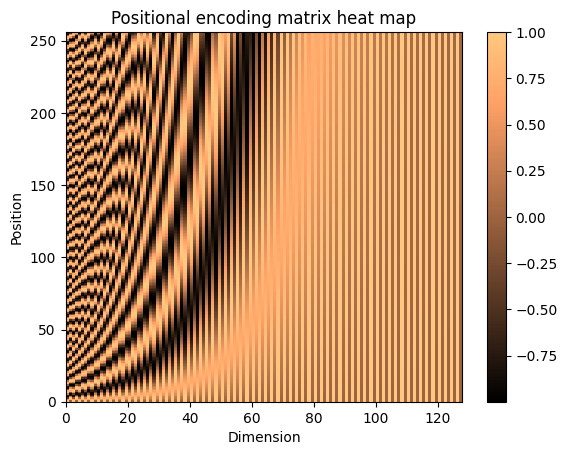

In [61]:
import numpy as np

def positional_encoding(max_position, model_dim, min_freq=1e-4):
    position = np.arange(max_position)
    freqs = min_freq**(2*(np.arange(model_dim)//2)/model_dim)
    pos_enc = position.reshape(-1,1)*freqs.reshape(1,-1)
    pos_enc[:, ::2] = np.cos(pos_enc[:, ::2])
    pos_enc[:, 1::2] = np.sin(pos_enc[:, 1::2])
    return pos_enc
    
model_dim = 128
max_pos = 256
mat = positional_encoding(max_pos, model_dim)
plt.pcolormesh(mat, cmap='copper')
plt.xlabel('Dimension')
plt.xlim((0, model_dim))
plt.ylabel('Position')
plt.title("Positional encoding matrix heat map")
plt.colorbar()
plt.show()

This model is just an illustration of what can be done with a single head plus positional encoding.

In [62]:
class SingleHeadPositional(nn.Module):
    
    def __init__(self, head_size, head_output_dim):
        super().__init__()
        self.token_embedding_table = nn.Embedding(n_token, n_embed)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        self.self_attention_head = Head(head_input_dim = n_embed, 
                                        head_size = head_size, 
                                        head_output_dim = head_output_dim)
        self.last_head = nn.Linear(head_output_dim, n_token)

    def forward(self, idx, y=None):
        B, T = idx.shape
        # if training: B = batch_size, else B = 1
        # T = block_size
        # I = head_input_dim = n_embed
        # H = head_size
        # O = head_output_dim

        tok_emb = self.token_embedding_table(idx) # (B, T, I)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T, I)
        x = tok_emb + pos_emb # (B, T, I)

        x = self.self_attention_head(x) # (B, T, H)
        logits = self.last_head(x) # (B, T, O)
        
        if y is None:
            loss = None
        else:
            logits = logits.view(B * T, n_token)
            y = y.view(B * T)
            loss = F.cross_entropy(logits, y)
        return logits, loss        

In [63]:
model = SingleHeadPositional(head_size = 16, head_output_dim = n_embed)
print(sum(p.numel() for p in model.parameters())/1e6, ' M parameters')
train(model, n_iterations = 20000, learning_rate = 1e-3, eval_interval = 1000, eval_iters = 100)
print(generate(model, max_new_tokens = 200))

0.073216  M parameters
step 0: train loss 6.2659, val loss 6.2672
step 1000: train loss 3.9792, val loss 4.0826
step 2000: train loss 3.7701, val loss 3.9050
step 3000: train loss 3.6912, val loss 3.8329
step 4000: train loss 3.6539, val loss 3.7981
step 5000: train loss 3.5990, val loss 3.7563
step 6000: train loss 3.5929, val loss 3.7515
step 7000: train loss 3.5615, val loss 3.7229
step 8000: train loss 3.5391, val loss 3.7205
step 9000: train loss 3.5259, val loss 3.7091
step 10000: train loss 3.5217, val loss 3.6992
step 11000: train loss 3.4985, val loss 3.6899
step 12000: train loss 3.4895, val loss 3.6982
step 13000: train loss 3.4963, val loss 3.6893
step 14000: train loss 3.4960, val loss 3.6730
step 15000: train loss 3.4691, val loss 3.6552
step 16000: train loss 3.4756, val loss 3.6618
step 17000: train loss 3.4440, val loss 3.6526
step 18000: train loss 3.4572, val loss 3.6510
step 19000: train loss 3.4411, val loss 3.6506
step 19999: train loss 3.4372, val loss 3.6439
rts

### From single head to multi headed attention

In [64]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, n_head, head_size, head_output_dim):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_input_dim = n_embed, 
                                         head_size = head_size, 
                                         head_output_dim = head_output_dim) for _ in range(n_head)])
        self.proj = nn.Linear(n_head * head_output_dim, n_embed)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        return out

We enrich the previous model with parallel heads, called multi head.

In [67]:
class MultiHeadPositional(nn.Module):
    
    def __init__(self, n_head, head_size, head_output_dim):
        super().__init__()
        self.token_embedding_table = nn.Embedding(n_token, n_embed)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        self.self_attention_heads = MultiHeadAttention(n_head = n_head,
                                                      head_size = head_size,
                                                      head_output_dim = head_output_dim) 
        self.last_head = nn.Linear(n_embed, n_token)

    def forward(self, idx, y=None):
        B, T = idx.shape
        # B = either batch_size or 1
        # T = block_size
        # I = head_input_dim 
        
        tok_emb = self.token_embedding_table(idx) # (B, T, I)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T, I)
        x = tok_emb + pos_emb # (B, T, I)

        x = self.self_attention_heads(x) # (B, T, n_embed)
        logits = self.last_head(x) # (B, T, n_token)
        
        if y is None:
            loss = None
        else:
            logits = logits.view(B * T, n_token)
            y = y.view(B * T)
            loss = F.cross_entropy(logits, y)
        return logits, loss        

In [69]:
model = MultiHeadPositional(n_head = 6, 
                            head_size = 16,
                           head_output_dim = 16)
print(sum(p.numel() for p in model.parameters())/1e6, ' M parameters')
train(model, n_iterations = 20000, learning_rate = 1e-3, eval_interval = 1000, eval_iters = 100)
print(generate(model, max_new_tokens = 200))

0.091712  M parameters
step 0: train loss 6.2333, val loss 6.2324
step 1000: train loss 3.9679, val loss 4.0720
step 2000: train loss 3.6414, val loss 3.7989
step 3000: train loss 3.4855, val loss 3.6753
step 4000: train loss 3.3741, val loss 3.5942
step 5000: train loss 3.2868, val loss 3.5254
step 6000: train loss 3.2485, val loss 3.4385
step 7000: train loss 3.1815, val loss 3.4439
step 8000: train loss 3.1639, val loss 3.3787
step 9000: train loss 3.1516, val loss 3.3960
step 10000: train loss 3.1114, val loss 3.3804
step 11000: train loss 3.0980, val loss 3.3581
step 12000: train loss 3.0770, val loss 3.3264
step 13000: train loss 3.0731, val loss 3.3278
step 14000: train loss 3.0495, val loss 3.3184
step 15000: train loss 3.0494, val loss 3.3075
step 16000: train loss 3.0263, val loss 3.3055
step 17000: train loss 3.0054, val loss 3.3052
step 18000: train loss 3.0000, val loss 3.2799
step 19000: train loss 3.0117, val loss 3.2831
step 19999: train loss 2.9978, val loss 3.2583
the

## Some deep learning magic to make training easier

### Normalization layers

In [70]:
class LayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        xmean = x.mean(1, keepdim=True) # batch mean
        xvar = x.var(1, keepdim=True) # batch variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [71]:
module = LayerNorm(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

We compute the mean and standard deviation of one (the first) feature across all batch inputs:

In [72]:
x[:,0].mean(), x[:,0].std()
# NOT normalised

(tensor(-0.0526), tensor(1.2170))

Now, the mean and standard deviation of the features for a single input from the batch:

In [73]:
x[0,:].mean(), x[0,:].std()
# normalised

(tensor(-2.3842e-09), tensor(1.0000))

### Sequential blocks

In [74]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embed2, n_embed = n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, n_embed2),
            nn.Tanh(),
            nn.Linear(n_embed2, n_embed),
        )

    def forward(self, x):
        return self.net(x)

In [78]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_head, head_size, head_output_dim, n_embed2):
        super().__init__()
        self.self_attention_heads = MultiHeadAttention(n_head = n_head,
                                                       head_size = head_size,
                                                       head_output_dim = head_output_dim)
        self.ffwd = FeedFoward(n_embed2 = n_embed2, n_embed = n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        # here are skip connections, also called residual connections
        # they help training deep neural networks by adding a pathway to the input
        x = x + self.self_attention_heads(x)

        # normalization layer; recent implementations put them before self attention heads!
        x = self.ln1(x)
        
        # and again skip connections:
        x = x + self.ffwd(x)

        # and again normalization layer
        x = self.ln2(x)

        return x

This is the full model, almost as in the **Attention is all you need** paper (see below for differences).

In [79]:
class LanguageModel(nn.Module):

    def __init__(self, n_head, head_size, head_output_dim, n_embed2, n_layer):
        super().__init__()
        self.token_embedding_table = nn.Embedding(n_token, n_embed)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        self.blocks = nn.Sequential(*[Block(n_head, head_size, head_output_dim, n_embed2) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed, n_token)

    def forward(self, idx, y=None):
        B, T = idx.shape
        # I = head_input_dim = head_output_dim = n_embed

        tok_emb = self.token_embedding_table(idx) # (B, T, I)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T, I)
        x = tok_emb + pos_emb # (B, T, I)
        x = self.blocks(x) # (B, T, I)
        x = self.ln_f(x) # (B, T, I)
        logits = self.lm_head(x) # (B, T, n_token)

        if y is None:
            loss = None
        else:
            B, T, _ = logits.shape
            logits = logits.view(B*T, n_token)
            y = y.view(B*T)
            loss = F.cross_entropy(logits, y)

        return logits, loss

In [80]:
model = LanguageModel(n_head = 6, 
                      head_size = 16,
                      head_output_dim = 16,
                      n_embed2 = 4 * n_embed,
                      n_layer = 4)
print(sum(p.numel() for p in model.parameters())/1e6, ' M parameters')
train(model, n_iterations = 20000, learning_rate = 1e-3, eval_interval = 1000, eval_iters = 100)

0.299136  M parameters
step 0: train loss 6.4277, val loss 6.4319
step 1000: train loss 3.5585, val loss 3.7456
step 2000: train loss 3.2212, val loss 3.4427
step 3000: train loss 3.0763, val loss 3.2970
step 4000: train loss 2.9721, val loss 3.2600
step 5000: train loss 2.9348, val loss 3.1929
step 6000: train loss 2.8602, val loss 3.1688
step 7000: train loss 2.8175, val loss 3.1312
step 8000: train loss 2.7983, val loss 3.1315
step 9000: train loss 2.7726, val loss 3.0950
step 10000: train loss 2.7303, val loss 3.0961
step 11000: train loss 2.7118, val loss 3.0728
step 12000: train loss 2.7092, val loss 3.0548
step 13000: train loss 2.6923, val loss 3.0608
step 14000: train loss 2.6779, val loss 3.0434
step 15000: train loss 2.6740, val loss 3.0315
step 16000: train loss 2.6684, val loss 3.0333
step 17000: train loss 2.6473, val loss 3.0319
step 18000: train loss 2.6381, val loss 3.0331
step 19000: train loss 2.6296, val loss 2.9983
step 19999: train loss 2.6313, val loss 3.0057


In [81]:
print(generate(model, max_new_tokens = 500))

not cather, or minim of neability
should finced you still should genervightively sistricts
has talks that over the truths to cut threat as
congress that gance reportation will be achieved by a safe year of hadlan, and demoches them asia.
and leaders in the patriot count.
nuclear what record supporters of 202, set asin half that leaders from mobility for lay. althat
they dift they see our allies to achieving their leaders
nation.

income station,. i will know that the approach of the comflications. and we must go this economic scoping twice zest current mond. confircratip than syney.

but more than 60 years we had effort that decision to share the resump in fifting in that
future, seconds legislation, and i ask you and
unugged comidable tax didikura tax proposal should worry leavauta, to press the tools.
greateration than 1-year-old
again deathship with progress investments, we must balst haves, and has been deparee so preventages; the over
america's failedless safety state office and e

Machine translation requires an encoder-decoder architecture:
* the encoder encodes the input, using the exact same code as above, except that self attention is not masked (all tokens communicate with each other). To get an "encoder" attention block we just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
* the decoder is still auto-regressive, meaning it's conditioned on what's already been generated, but also on the result of the encoder. More specifically, the keys and values in each attention layer are coming from the encoder itself. The term "self-attention" means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module).

ChatGPT (or prompting) requires a fine-tuning phase (we covered only pre-training) where the network aligns with prompts and expected answers. It's based on reinforcement learning and a reward model for correct answers to prompts.